In [79]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as pgo
import plotly.offline as pyo
import plotly.io as pio
from plotly.subplots import make_subplots

pyo.init_notebook_mode(connected = True)

from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    cross_val_score,
    GroupShuffleSplit,
    permutation_test_score,
    StratifiedKFold,
    KFold
)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.ensemble import ExtraTreesClassifier

from utils import multivariate_classifier, plot_univariate, correct_name_markers

from scipy.stats import wilcoxon, mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [2]:
# plotting parameters
grey = "#21201F"
green = "#9AC529"
lblue = "#42B9B2"
pink = "#DE237B"
orange = "#F38A31"

nt_colors = [green, lblue, pink, orange]

plt.style.use("ggplot")
fig_width = 12  # width in inches
fig_height = 9  # height in inches
fig_size = [fig_width, fig_height]
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams["figure.autolayout"] = True

sns.set(
    style="white",
    context="notebook",
    font_scale=1,
    rc={
        "axes.labelcolor": grey,
        "text.color": grey,
        "axes.edgecolor": grey,
        "xtick.color": grey,
        "ytick.color": grey,
    },
)

sns.set_palette(sns.color_palette
(nt_colors))

# Load Data

In [103]:
markers = ['wSMI_1', 'wSMI_2', 'wSMI_4', 'wSMI_8', 'p_e_1', 'p_e_2',
       'p_e_4', 'p_e_8', 'k', 'se','msf', 'sef90', 'sef95', 'b', 'b_n', 'g',
       'g_n', 't', 't_n', 'd', 'd_n', 'a_n', 'a', 
#            'CNV', 'P1', 'P3a', 'P3b'
          ]
erps =['CNV', 'P1', 'P3a', 'P3b']

# Load Mindwandering DATA

In [80]:
epoch_type = "evoked"
# epoch_type = 'pseudo-rs'

all_participants = [
    "VP07",
    "VP08",
    "VP09",
    "VP10",
    "VP11",
    "VP12",
    "VP13",
    "VP14",
    "VP18",
    "VP19",
    "VP20",
    "VP22",
    "VP23",
    "VP24",
    "VP25",
    "VP26",
    "VP27",
    "VP28",
    "VP29",
    "VP30",
    "VP31",
    "VP32",
    "VP33",
    "VP35",
    "VP36",
    "VP37",
]

path = "/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/"  # icm-linux
# path = '/Users/nicobruno/ownCloud/MW_eeg_data/minmarker/' #nico-mac

df = pd.DataFrame()

for i, v in enumerate(all_participants):
    participant = v

    folder = path + participant + "/"

    df_ = pd.read_csv(
        folder + participant + "_" + epoch_type + "_all_marker.csv", index_col=0
    )
    df_["participant"] = i
    df = df.append(df_)




# markers =  [r'$\delta$',r'$|\delta|$',r'$\theta$', r'$|\theta|$',r'$\alpha$', r'$|\alpha|$',r'$\beta$', r'$|\beta|$',r'$\gamma$', r'$|\gamma|$',
#             r'$PE\gamma$',r'$PE\beta$',r'$PE\alpha$',r'$PE\theta$',
#             r'$wSMI\gamma$',r'$wSMI\beta$',r'$wSMI\alpha$',r'$wSMI\theta$', 
#             r'$K$',r'$SE$',r'$MSF$', r'$SEF90$', r'$SEF95$', 
#             r'$CNV$', r'$P1$', r'$P3a$',r'$P3b$'
#            ]


# df_subtracted = df.query("preproc == 'subtracted'").drop(columns = erps+['preproc'])
# df_erp = df.query("preproc == 'erp'").drop(columns = np.setdiff1d(markers,erps).tolist()+['preproc'])

# df_markers = df_subtracted.merge(df_erp, 'inner', on =np.setdiff1d(df_subtracted.columns, markers).tolist() )

df_markers = (df
              .query("stimuli == 'go'")
              .query("correct == 'correct'")
            .query('prev_trial < 5')
              .drop(['stimuli', 'correct', 'prev_trial', 'label', 'events',  'epoch_type', 'preproc'], axis = 1)
              .drop(erps, axis=1)
              .query("mind in ['on-task','dMW', 'sMW']")
              .groupby(['segment', 'participant']).filter(lambda x: len(x) > 1)
             )

# df_markers.to_csv('Data/all_markers.csv')


agg_dict = {k: ["mean", 'std'] for k in markers}
agg_dict.update({k: "first" for k in df_markers.drop(markers, axis=1).columns})

df_mind = (
    df_markers.query("probe == 'PC'")
    .groupby(["segment", "participant"], as_index=False)
    .agg(agg_dict)
    #     .query("mind != 'sMW'") #if you want to test against just one of the mw
    .assign(mind2=lambda df: np.where(df.mind == "on-task", "on-task", "mw"))
)

# df_mind.columns = df_mind.columns.map("_".join)

# df_mind = df_mind.rename(
#    columns={
#        "participant_first": "participant",
#        "probe_first": "probe",
#        "mind_first": "mind",
#        "segment_first": "segment",
#        "mind2_": "mind2",
#    }
# ).drop(["participant", "probe", "mind", "segment"], axis=1)

#### Use latex command for nmaes###
##it slow downs the computer, just for final figures.

df_mind = correct_name_markers(df_mind)

df_mind.columns = df_mind.columns.map("$_{".join).map(lambda x: x + '}$').map(lambda x: x.replace('$$', ''))

df_mind  = (df_mind
            .rename(columns = {'participant$_{first}$':'participant', 'probe$_{first}$':'probe', 'mind$_{first}$':'mind', 'segment$_{first}$':'segment', 'mind2$_{}$':'mind2'})
#             .query("mind != 'dMW'") #if you want to test against just one of the mw            
            .drop(['participant', 'probe', 'mind', 'segment'], axis = 1) 
           )

# Load DOC patients DATA

In [83]:
path = "/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/DOC patients/DOC_markers/"

classes = os.listdir(path)
classes

['HC', 'EMCS', 'MCS', 'VS']

In [84]:
df = pd.DataFrame()

for i in classes:
    
    files = os.listdir(path + i + '/')
    cat = i

    for file in files:
        
        participant = file[:7]
        
        df_ = pd.read_csv(path + i + '/' + file, index_col=0)
        df_["participant"] = participant
        df_['category'] = cat
        
        df = df.append(df_)
        
             
df = df.assign(cat_order = lambda df: np.select([df.category == 'HC', df.category == 'MCS', df.category == 'VS'], [3,2,1]) )



# AUC mind

In [111]:
AUC = []
pvalues = {}
for i in df_mind.drop('mind2', axis = 1).columns:
    ot = df_mind.query("mind2 == 'on-task'")[i]
    mw = df_mind.query("mind2 == 'mw'")[i]
    auc = roc_auc_score(df_mind['mind2'], df_mind[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = ot, y = mw)}')
    AUC.append([i, auc])
    pvalues[i] = mannwhitneyu(x = ot, y = mw).pvalue 
        
segment_mind_roc = pd.DataFrame(AUC, columns = ['markers', 'AUC'])

p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
segment_mind_roc = (segment_mind_roc
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(
                    p_corrected = lambda df: multipletests(df.p_value, method = 'fdr_bh')[1],
                    significant = lambda df: np.select([(df.p_value < 0.05) & (df.p_corrected < 0.05), (df.p_value < 0.05) & (df.p_corrected > 0.05),  
                                                 (df.p_value > 0.05) & (df.p_corrected > 0.05)], ['p < 0.05 FDR corrected','p < 0.05 uncorrected', 'p > 0.05'])
                   )
           )


AUC $wSMI\gamma_{mean}$ = 0.5107680332122471 MannwhitneyuResult(statistic=3771.0, pvalue=0.4033545912859166)
AUC $wSMI\gamma_{std}$ = 0.5546185781006746 MannwhitneyuResult(statistic=3433.0, pvalue=0.10618154413430386)
AUC $wSMI\beta_{mean}$ = 0.5332122470160872 MannwhitneyuResult(statistic=3598.0, pvalue=0.22430132448909945)
AUC $wSMI\beta_{std}$ = 0.4577062791904515 MannwhitneyuResult(statistic=3528.0, pvalue=0.1671851415098402)
AUC $wSMI\alpha_{mean}$ = 0.5464452516865594 MannwhitneyuResult(statistic=3496.0, pvalue=0.14451493909974722)
AUC $wSMI\alpha_{std}$ = 0.5444992215879606 MannwhitneyuResult(statistic=3511.0, pvalue=0.15487039247687662)
AUC $wSMI\theta_{mean}$ = 0.5459263103269332 MannwhitneyuResult(statistic=3500.0, pvalue=0.1472296544752783)
AUC $wSMI\theta_{std}$ = 0.4910482615464452 MannwhitneyuResult(statistic=3785.0, pvalue=0.4195076380470079)
AUC $PE\gamma_{mean}$ = 0.516476388168137 MannwhitneyuResult(statistic=3727.0, pvalue=0.3537684464398442)
AUC $PE\gamma_{std}$ = 0

# AUC DOC patients

In [137]:
classification = ['VS', 'MCS']

#df = df.drop(erps, axis = 1)

agg_dict = {k: ["mean", 'std'] for k in markers}
agg_dict.update({k: "first" for k in df.drop(markers, axis=1).columns})

df_doc = (
    df.query(f"category in {classification}")
    .groupby(["participant", 'category'], as_index=False)
    .agg(agg_dict)
)

# df_doc.columns = df_doc.columns.map("_".join)

# df_doc = df_doc.rename(
#    columns={
#        "participant_first": "participant",
#        "category_first": "category",
#        "cat_order_first":"cat_order"
#    }
# ).drop(["participant"], axis=1)


#### Use latex command for nmaes###
##it slow downs the computer, just for final figures.

df_doc = correct_name_markers(df_doc)

df_doc.columns = df_doc.columns.map("$_{".join).map(lambda x: x + '}$').map(lambda x: x.replace('$$', ''))

df_doc  = (df_doc
            .rename(columns = {'participant$_{first}$':'participant', 'category$_{first}$':'category', 'cat_order$_{first}$':'cat_order'})        
            .drop(['participant'], axis = 1) 
           )

In [138]:
AUC = []
pvalues = {}
for i in df_doc.drop(['category', 'cat_order'], axis = 1).columns:
    vs = df_doc.query("category == 'VS'")[i]
    mcs = df_doc.query("category == 'MCS'")[i]
    auc = roc_auc_score(df_doc['cat_order'], df_doc[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = vs, y = mcs)}')
    AUC.append([i, auc])
    pvalues[i] = mannwhitneyu(x = vs, y = mcs).pvalue 
        
roc_vs_mcs = pd.DataFrame(AUC, columns = ['markers', 'AUC'])

p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
roc_vs_mcs = (roc_vs_mcs
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(
                    p_corrected = lambda df: multipletests(df.p_value, method = 'fdr_bh')[1],
                    significant = lambda df: np.select([(df.p_value < 0.05) & (df.p_corrected < 0.05), (df.p_value < 0.05) & (df.p_corrected > 0.05),  
                                                 (df.p_value > 0.05) & (df.p_corrected > 0.05)], ['p < 0.05 FDR corrected','p < 0.05 uncorrected', 'p > 0.05'])
                   )
           )


AUC $wSMI\gamma_{mean}$ = 0.42008856682769724 MannwhitneyuResult(statistic=2087.0, pvalue=0.05099252972369192)
AUC $wSMI\gamma_{std}$ = 0.5396537842190017 MannwhitneyuResult(statistic=2287.0, pvalue=0.2088450918473836)
AUC $wSMI\beta_{mean}$ = 0.43981481481481477 MannwhitneyuResult(statistic=2185.0, pvalue=0.10913920197517435)
AUC $wSMI\beta_{std}$ = 0.5197262479871175 MannwhitneyuResult(statistic=2386.0, pvalue=0.34379629031855363)
AUC $wSMI\alpha_{mean}$ = 0.4492753623188406 MannwhitneyuResult(statistic=2232.0, pvalue=0.14980400369663027)
AUC $wSMI\alpha_{std}$ = 0.5416666666666666 MannwhitneyuResult(statistic=2277.0, pvalue=0.1971962624537637)
AUC $wSMI\theta_{mean}$ = 0.6312399355877616 MannwhitneyuResult(statistic=1832.0, pvalue=0.0036046866609333802)
AUC $wSMI\theta_{std}$ = 0.6564009661835748 MannwhitneyuResult(statistic=1707.0, pvalue=0.0006810623593173185)
AUC $PE\gamma_{mean}$ = 0.44082125603864736 MannwhitneyuResult(statistic=2190.0, pvalue=0.11304409636720825)
AUC $PE\gamma

# DOC vs Mind

In [139]:
df_contrast = (segment_mind_roc.merge(roc_vs_mcs, on = 'markers', suffixes=('_mind', '_doc'))
               .assign(significant= lambda df: np.select([(df.significant_mind != "p > 0.05" )& (df.significant_doc == "p > 0.05"),
                                                          (df.significant_mind == "p > 0.05" )& (df.significant_doc != "p > 0.05"),
                                                         (df.significant_mind != "p > 0.05" )& (df.significant_doc != "p > 0.05"),
                                                         (df.significant_mind == "p > 0.05" )& (df.significant_doc == "p > 0.05")],
                                                         ['Significant mind', 'Significant DOC', 'Significant Both', 'Not significant']))
              )

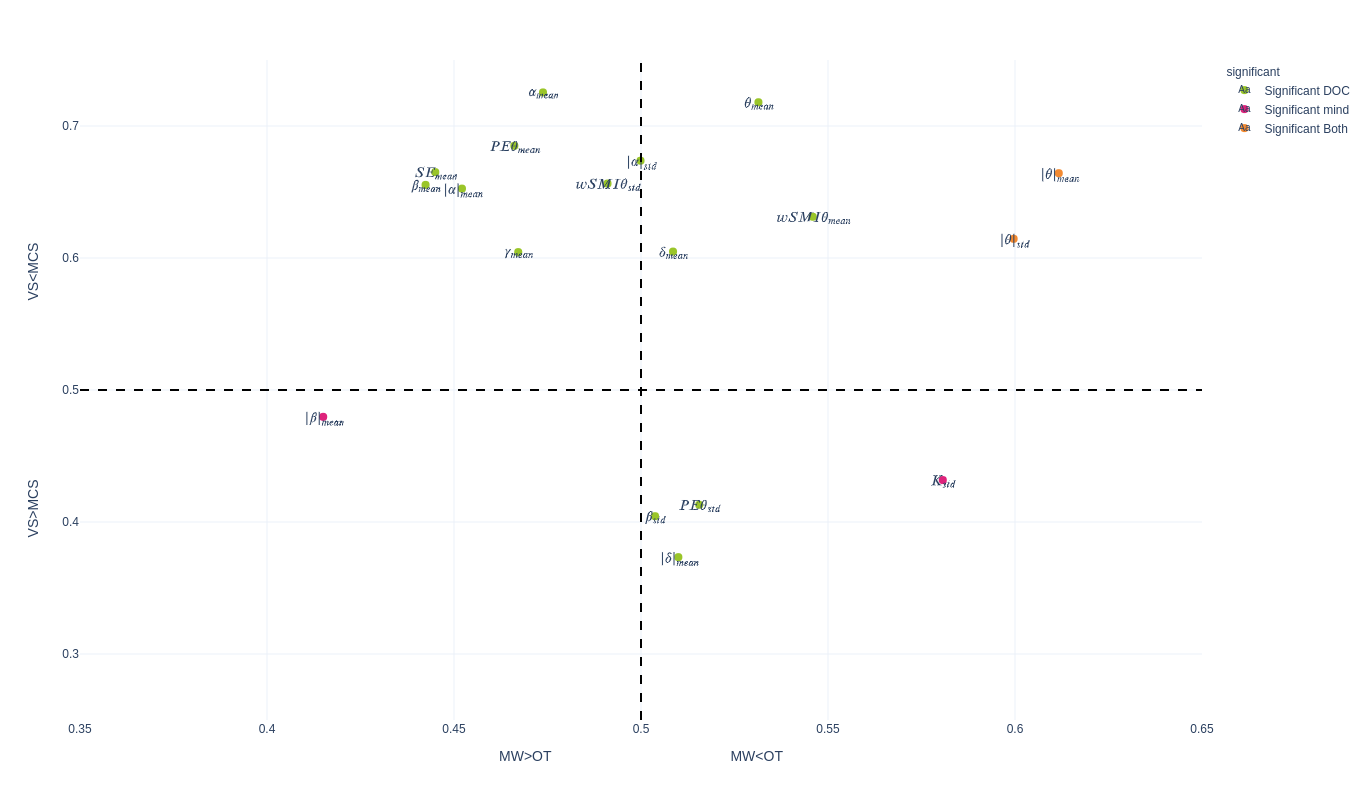

In [140]:
fig = px.scatter(df_contrast.query("significant != 'Not significant'"),x = 'AUC_mind', y = 'AUC_doc', template = "plotly_white", text = 'markers',
                 color_discrete_sequence = [green,pink, orange, lblue],
                 color = 'significant',
                #symbol_sequence = ['circle-open','circle','hexagram' ],

                 #category_orders = {'significant': ['p > 0.05','p < 0.05 uncorrected', 'p < 0.05 FDR corrected']}, 
                 labels = {'AUC_mind': f'MW>OT                                              MW<OT', 
                           'AUC_doc':'VS>MCS                                              VS<MCS'}

                )

fig.add_vline(x=0.5, line_width=2, line_dash="dash", line_color="black")
fig.add_hline(y=0.5, line_width=2, line_dash="dash", line_color="black")

fig.update_traces(marker=dict(size = 8))

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis= {'range': (0.35, 0.65),
            #'showticklabels': True,
            #'tickmode': 'linear'
           },
    yaxis = {'range': (0.25, 0.75),
            #'showticklabels': True,
            #'tickmode': 'linear',
        }

)

fig.show()

 # HC vs MCS

In [120]:
classification = ['HC', 'MCS']

#df = df.drop(erps, axis = 1)

agg_dict = {k: ["mean", 'std'] for k in markers}
agg_dict.update({k: "first" for k in df.drop(markers, axis=1).columns})

df_doc = (
    df.query(f"category in {classification}")
    .groupby(["participant", 'category'], as_index=False)
    .agg(agg_dict)
)

# df_doc.columns = df_doc.columns.map("_".join)

# df_doc = df_doc.rename(
#    columns={
#        "participant_first": "participant",
#        "category_first": "category",
#        "cat_order_first":"cat_order"
#    }
# ).drop(["participant"], axis=1)


#### Use latex command for nmaes###
##it slow downs the computer, just for final figures.

df_doc = correct_name_markers(df_doc)

df_doc.columns = df_doc.columns.map("$_{".join).map(lambda x: x + '}$').map(lambda x: x.replace('$$', ''))

df_doc  = (df_doc
            .rename(columns = {'participant$_{first}$':'participant', 'category$_{first}$':'category', 'cat_order$_{first}$':'cat_order'})        
            .drop(['participant'], axis = 1) 
           )

In [124]:
AUC = []
pvalues = {}
for i in df_doc.drop(['category', 'cat_order'], axis = 1).columns:
    hc = df_doc.query("category == 'HC'")[i]
    mcs = df_doc.query("category == 'MCS'")[i]
    auc = roc_auc_score(df_doc['cat_order'], df_doc[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = vs, y = mcs)}')
    AUC.append([i, auc])
    pvalues[i] = mannwhitneyu(x = vs, y = mcs).pvalue 
        
roc_vs_mcs = pd.DataFrame(AUC, columns = ['markers', 'AUC'])

p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
roc_vs_mcs = (roc_vs_mcs
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(
                    p_corrected = lambda df: multipletests(df.p_value, method = 'fdr_bh')[1],
                    significant = lambda df: np.select([(df.p_value < 0.05) & (df.p_corrected < 0.05), (df.p_value < 0.05) & (df.p_corrected > 0.05),  
                                                 (df.p_value > 0.05) & (df.p_corrected > 0.05)], ['p < 0.05 FDR corrected','p < 0.05 uncorrected', 'p > 0.05'])
                   )
           )


AUC $wSMI\gamma_{mean}$ = 0.5229142185663925 MannwhitneyuResult(statistic=0.0, pvalue=6.372859058264791e-25)
AUC $wSMI\gamma_{std}$ = 0.3176654915785351 MannwhitneyuResult(statistic=0.0, pvalue=6.372859058264791e-25)
AUC $wSMI\beta_{mean}$ = 0.5863689776733255 MannwhitneyuResult(statistic=0.0, pvalue=6.372859058264791e-25)
AUC $wSMI\beta_{std}$ = 0.4571092831962398 MannwhitneyuResult(statistic=0.0, pvalue=6.372859058264791e-25)
AUC $wSMI\alpha_{mean}$ = 0.8127692910301606 MannwhitneyuResult(statistic=0.0, pvalue=6.372859058264791e-25)
AUC $wSMI\alpha_{std}$ = 0.7947512730121425 MannwhitneyuResult(statistic=0.0, pvalue=6.372859058264791e-25)
AUC $wSMI\theta_{mean}$ = 0.63650607128868 MannwhitneyuResult(statistic=0.0, pvalue=6.372859058264791e-25)
AUC $wSMI\theta_{std}$ = 0.6521739130434783 MannwhitneyuResult(statistic=0.0, pvalue=6.372859058264791e-25)
AUC $PE\gamma_{mean}$ = 0.4676850763807286 MannwhitneyuResult(statistic=0.0, pvalue=6.372859058264791e-25)
AUC $PE\gamma_{std}$ = 0.4998

# DOC vs Mind

In [125]:
df_contrast = (segment_mind_roc.merge(roc_vs_mcs, on = 'markers', suffixes=('_mind', '_doc'))
               .assign(significant= lambda df: np.select([(df.significant_mind != "p > 0.05" )& (df.significant_doc == "p > 0.05"),
                                                          (df.significant_mind == "p > 0.05" )& (df.significant_doc != "p > 0.05"),
                                                         (df.significant_mind != "p > 0.05" )& (df.significant_doc != "p > 0.05"),
                                                         (df.significant_mind == "p > 0.05" )& (df.significant_doc == "p > 0.05")],
                                                         ['Significant mind', 'Significant DOC', 'Significant Both', 'Not significant']))
              )

In [127]:
df_contrast

,markers,AUC_mind,p_value_mind,p_corrected_mind,significant_mind,AUC_doc,p_value_doc,p_corrected_doc,significant_doc,significant
0,$wSMI\gamma_{mean}$,0.510768,0.403355,0.452498,p > 0.05,0.522914,6.372859e-25,8.143098e-25,p < 0.05 FDR corrected,Significant DOC
1,$wSMI\gamma_{std}$,0.554619,0.106182,0.398317,p > 0.05,0.317665,6.372859e-25,8.143098e-25,p < 0.05 FDR corrected,Significant DOC
2,$wSMI\beta_{mean}$,0.533212,0.224301,0.398317,p > 0.05,0.586369,6.372859e-25,8.143098e-25,p < 0.05 FDR corrected,Significant DOC
3,$wSMI\beta_{std}$,0.457706,0.167185,0.398317,p > 0.05,0.457109,6.372859e-25,8.143098e-25,p < 0.05 FDR corrected,Significant DOC
4,$wSMI\alpha_{mean}$,0.546445,0.144515,0.398317,p > 0.05,0.812769,6.372859e-25,8.143098e-25,p < 0.05 FDR corrected,Significant DOC
5,$wSMI\alpha_{std}$,0.544499,0.154870,0.398317,p > 0.05,0.794751,6.372859e-25,8.143098e-25,p < 0.05 FDR corrected,Significant DOC
6,$wSMI\theta_{mean}$,0.545926,0.147230,0.398317,p > 0.05,0.636506,6.372859e-25,8.143098e-25,p < 0.05 FDR corrected,Significant DOC
7,$wSMI\theta_{std}$,0.491048,0.419508,0.452498,p > 0.05,0.652174,6.372859e-25,8.143098e-25,p < 0.05 FDR corrected,Significant DOC
8,$PE\gamma_{mean}$,0.516476,0.353768,0.452498,p > 0.05,0.467685,6.372859e-25,8.143098e-25,p < 0.05 FDR corrected,Significant DOC
9,$PE\gamma_{std}$,0.566295,0.065012,0.393676,p > 0.05,0.499804,6.372859e-25,8.143098e-25,p < 0.05 FDR corrected,Significant DOC


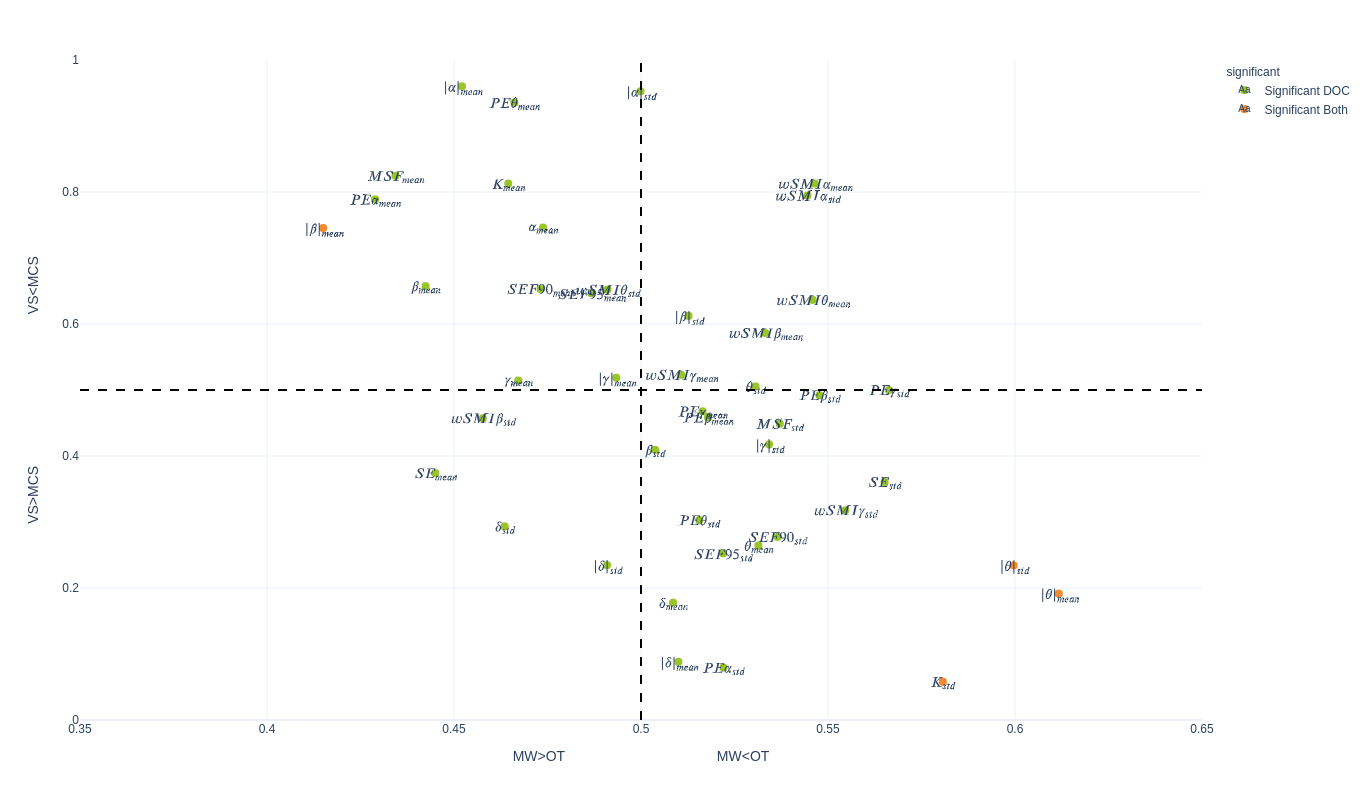

In [132]:
fig = px.scatter(df_contrast.query("significant != 'Not significant'"),x = 'AUC_mind', y = 'AUC_doc', template = "plotly_white", text = 'markers',
                 color_discrete_sequence = [green, orange, lblue],
                 color = 'significant',
                #symbol_sequence = ['circle-open','circle','hexagram' ],

                 #category_orders = {'significant': ['p > 0.05','p < 0.05 uncorrected', 'p < 0.05 FDR corrected']}, 
                 labels = {'AUC_mind': f'MW>OT                                       MW<OT', 
                           'AUC_doc':'VS>MCS                                       VS<MCS'}

                )

fig.add_vline(x=0.5, line_width=2, line_dash="dash", line_color="black")
fig.add_hline(y=0.5, line_width=2, line_dash="dash", line_color="black")

fig.update_traces(marker=dict(size = 8))

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis= {'range': (0.35, 0.65),
            #'showticklabels': True,
            #'tickmode': 'linear'
           },
    yaxis = {'range': (0, 1),
            #'showticklabels': True,
            #'tickmode': 'linear',
        }

)

fig.show()